In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DummyBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

class DummyPromptEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 32)

    def forward(self, points):
        return self.linear(points.float())

class DummyDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(32, 1, 1)

    def forward(self, features):
        return torch.sigmoid(self.conv(features))

class SAM2Tiny(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = DummyBackbone()
        self.prompt_encoder = DummyPromptEncoder()
        self.decoder = DummyDecoder()

    def forward(self, image, point=None):
        features = self.backbone(image)
        mask = self.decoder(features)
        return mask


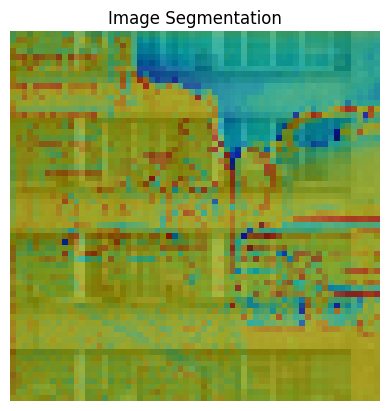

In [6]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('content/image.jpg')
img = cv2.resize(img, (256, 256))
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
tensor = torch.tensor(rgb).permute(2, 0, 1).unsqueeze(0) / 255.0

model = SAM2Tiny()
with torch.no_grad():
    mask = model(tensor)[0, 0].numpy()

plt.imshow(rgb)
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.title("Image Segmentation")
plt.axis('off')
plt.show()


In [7]:
def generate_point_prompts(H, W, grid_size=5):
    points = []
    step_h, step_w = H // grid_size, W // grid_size
    for i in range(grid_size):
        for j in range(grid_size):
            points.append([j * step_w, i * step_h])
    return torch.tensor(points)


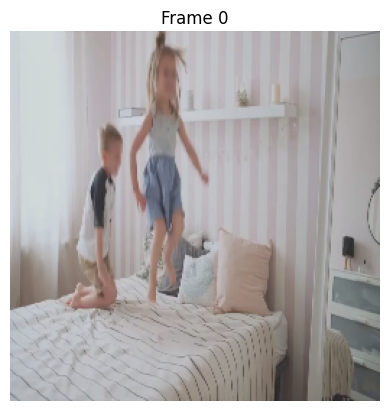

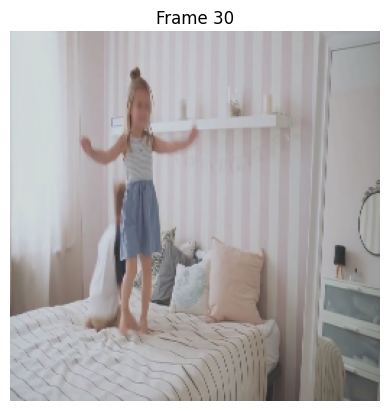

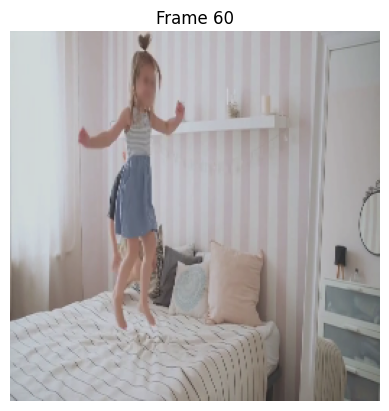

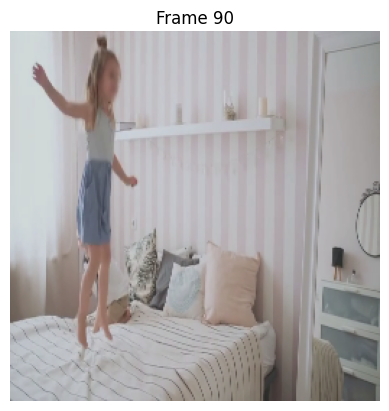

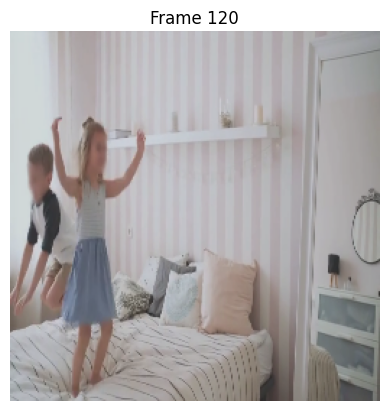

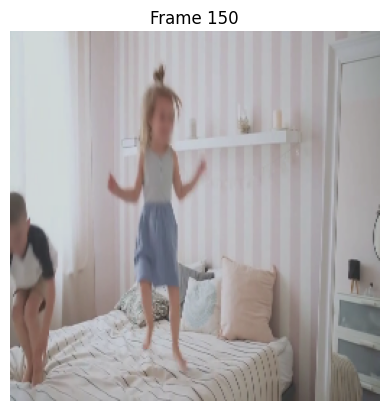

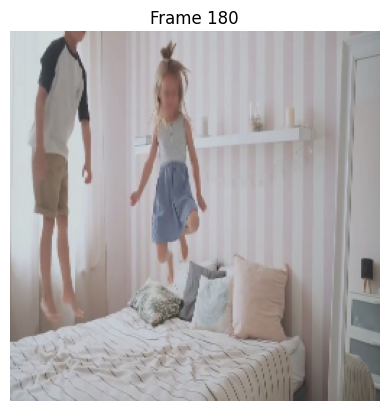

In [17]:
cap = cv2.VideoCapture('content/video.mp4')
model = SAM2Tiny()

frame_id = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if frame_id % 30 != 0:
        frame_id += 1
        continue

    frame = cv2.resize(frame, (256, 256))
    tensor = torch.tensor(frame).permute(2, 0, 1).unsqueeze(0) / 255.0

    with torch.no_grad():
        mask = model(tensor)[0, 0].numpy()

    # Resize mask to match the frame size
    mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]))

# Convert mask to RGB
    mask_rgb = (mask_resized * 255).astype('uint8')
    mask_rgb = cv2.merge([mask_rgb, mask_rgb, mask_rgb])

# Blend images
    overlaid = cv2.addWeighted(frame, 0.7, mask_rgb, 0.3, 0)

    plt.imshow(cv2.cvtColor(overlaid, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Frame {frame_id}")
    plt.show()

    frame_id += 1

cap.release()
